In [12]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
from sklearn.preprocessing import StandardScaler

In [3]:
data_dir = '/Users/xiaoqianxiao/UKB/data'
participantsInfo_file = 'participants.csv'
participantsInfo_file_path = os.path.join(data_dir,participantsInfo_file)
data_df = pd.read_csv(participantsInfo_file_path)

In [4]:
# cognitive function https://biobank.ndph.ox.ac.uk/showcase/label.cgi?id=100026
ReactionTime_fields = ['20023'] #i2 for scan day
NumericMemoryTest_fields = ['4282'] #i1 for scan day
FluidIntelligence_fields = ['20016'] #i2 for scan day
TrailMaking_fields = ['6348', '6349', '6350', '6351', '6770', '6771', '6772', '6773'] #i0 for scan day
Matrix_Pattern_Completion_fields = ['6373', '6374', '6332', '6333'] #i0 for scan day
SymbolDigitSubstitution_fields = ['20159']  #i0 for year 2014
TowerRearranging_fields = ['21004'] #i0 for scan day
ProspectiveMemory_fields = ['20018'] #i2 for scan day
PairsMatching_fields = ['399'] #i2 for scan day
CognitiveFunction_fields = ReactionTime_fields + NumericMemoryTest_fields +\
                            FluidIntelligence_fields + TrailMaking_fields +\
                            Matrix_Pattern_Completion_fields + SymbolDigitSubstitution_fields +\
                            TowerRearranging_fields + ProspectiveMemory_fields +\
                            PairsMatching_fields

In [5]:
pattern = r'^p(' + '|'.join(CognitiveFunction_fields) + r')_i0(_a\d+)?$'
CognitiveFunction_df = data_df.filter(regex=pattern).copy()

In [7]:
CognitiveFunction_df.columns

Index(['p20016_i0', 'p4282_i0', 'p20018_i0', 'p20023_i0', 'p20159_i0'], dtype='object')

In [6]:
CognitiveFunction_df.shape

(502131, 5)

KMO Test: 0.610 (should be > 0.6)
Bartlett’s Test: χ² = 3826.57, p = 0.0000


/Users/xiaoqianxiao/PycharmProjects/UKB_local/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


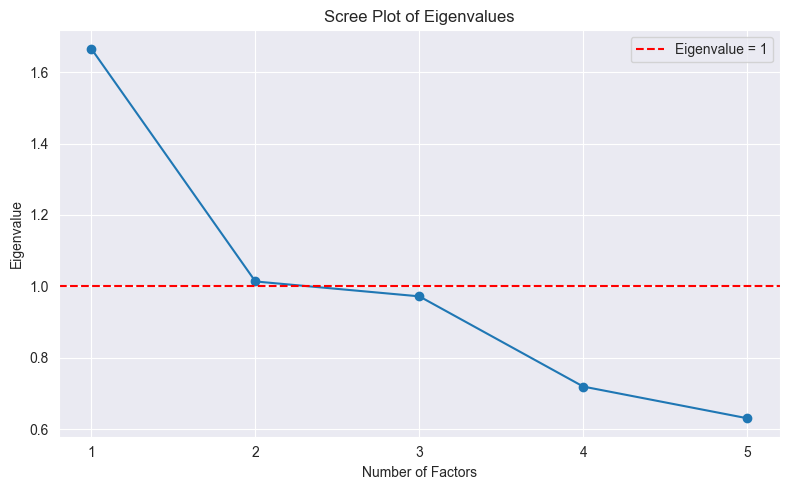

In [8]:
# ---- Step 2: Load your dataset ----
df_cog = CognitiveFunction_df.dropna()

# ---- Step 3: Run KMO and Bartlett's Test ----
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cog)

kmo_all, kmo_model = calculate_kmo(X_scaled)
print(f"KMO Test: {kmo_model:.3f} (should be > 0.6)")

chi_square_value, p_value = calculate_bartlett_sphericity(df_cog)
print(f"Bartlett’s Test: χ² = {chi_square_value:.2f}, p = {p_value:.4f}")

# ---- Step 4: Fit FA model to get eigenvalues ----
fa = FactorAnalyzer(rotation=None)
fa.fit(X_scaled)
ev, v = fa.get_eigenvalues()

# ---- Step 5: Scree Plot to decide number of factors ----
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(ev) + 1), ev, marker='o', linestyle='-')
plt.axhline(y=1, color='red', linestyle='--', label='Eigenvalue = 1')
plt.title('Scree Plot of Eigenvalues')
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(ev) + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Factor Loadings:
           Factor1  Factor2
p20016_i0     0.72    -0.14
p4282_i0      0.46    -0.07
p20018_i0    -0.13     0.07
p20023_i0    -0.06     0.56
p20159_i0     0.31    -0.42


/Users/xiaoqianxiao/PycharmProjects/UKB_local/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


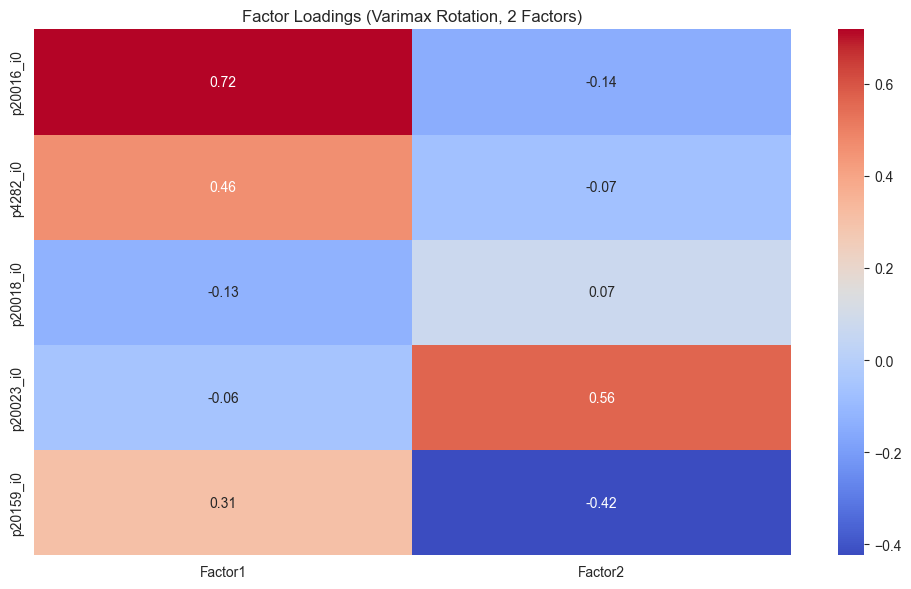


Communalities:
p20016_i0    0.54
p4282_i0     0.22
p20018_i0    0.02
p20023_i0    0.32
p20159_i0    0.27
dtype: float64

Uniquenesses:
p20016_i0    0.46
p4282_i0     0.78
p20018_i0    0.98
p20023_i0    0.68
p20159_i0    0.73
dtype: float64


In [14]:
# Run EFA with chosen number of factors
n_factors = 2  # Adjust based on scree plot or theory
fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
fa.fit(X_scaled)
#Extract Loadings
loadings = pd.DataFrame(fa.loadings_,
                        #index=CognitiveFunction_fields,
                        index=CognitiveFunction_df.columns,
                        columns=[f'Factor{i+1}' for i in range(n_factors)])
print("Factor Loadings:")
print(loadings.round(2))
#Visualize Loadings
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Factor Loadings (Varimax Rotation, {n_factors} Factors)")
plt.tight_layout()
plt.show()
#Get Communalities and Uniquenesses 
communalities = pd.Series(fa.get_communalities(), index=CognitiveFunction_df.columns)
uniquenesses = pd.Series(fa.get_uniquenesses(), index=CognitiveFunction_df.columns)
# communalities = pd.Series(fa.get_communalities(), index=CognitiveFunction_fields)
# uniquenesses = pd.Series(fa.get_uniquenesses(), index=CognitiveFunction_fields)
print("\nCommunalities:")
print(communalities.round(2))
print("\nUniquenesses:")
print(uniquenesses.round(2))

In [17]:
## Assessing the Overall Factor Model
#Kaiser-Meyer-Olkin (KMO) Measure: Assesses sampling adequacy for each variable and for the whole model.
# 0.90 = Marvelous
# 0.80 = Meritorious
# 0.70 = Middling
# 0.60 = Mediocre (minimum threshold)
# < 0.50 = Unacceptable
from factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(X_scaled)
print(f"KMO = {kmo_model:.3f}")

# Bartlett's Test of Sphericity: Tests if your correlation matrix is significantly different from an identity matrix (i.e., if factor analysis is appropriate)
from factor_analyzer import calculate_bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(df_cog)
print(f"Bartlett's test: χ² = {chi_square_value:.2f}, p = {p_value:.4f}")

KMO = 0.610
Bartlett's test: χ² = 3826.57, p = 0.0000


Bartlett's test: χ² = 3826.57, p = 0.0000
